✅ Libraries imported.
Loading Data...
Original Arabic Samples: 3180
Final Cleaned Dataset: 2290
Loading FastText (This takes memory)...
Original Train Counts: Counter({4: 1285, 1: 448, 0: 68, 3: 26, 2: 5})
Applying SMOTE...
Balanced Train Counts: Counter({4: 1285, 1: 1285, 0: 1285, 3: 1285, 2: 5})
--------------------------------------------------------------------------------
MODEL 1: SUPPORT VECTOR MACHINE (SVM)
--------------------------------------------------------------------------------
                                          precision    recall  f1-score   support

                   Biased against Israel       0.00      0.00      0.00        17
                Biased against Palestine       0.40      0.51      0.45       112
Biased against both Palestine and Israel       0.00      0.00      0.00         1
                   Biased against others       0.00      0.00      0.00         7
                                Unbiased       0.77      0.72      0.74       321

       

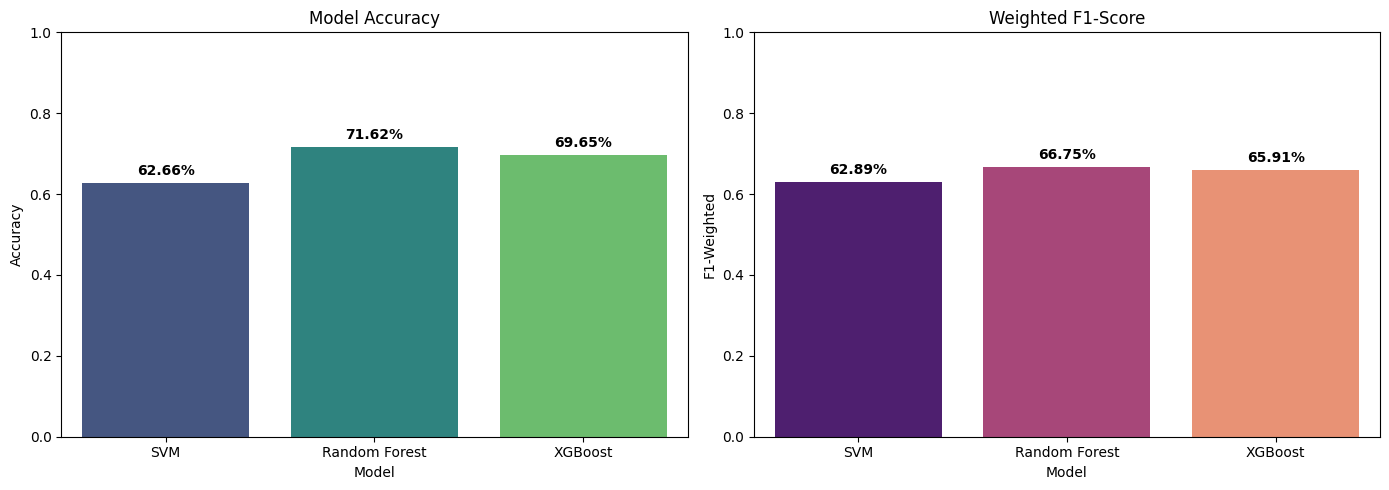

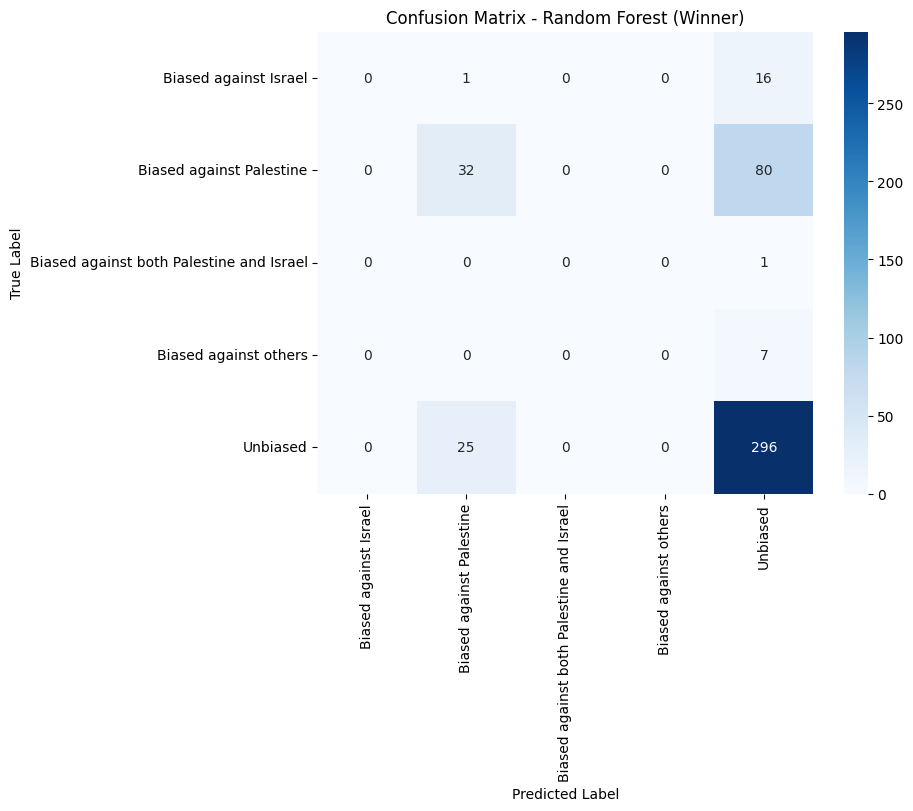

In [3]:
# ==============================================================================
# CELL 1: CLASSICAL ML - IMPORTS & CONFIGURATION
# ==============================================================================
import pandas as pd
import numpy as np
import re
import os
import fasttext
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

print("✅ Libraries imported.")

# ⚙️ CONFIG - UPDATE PATHS FOR YOUR LOCAL MACHINE
DATA_DIR = "BiasFignews/data/"
# Ensure this path points to your local 7GB file
FASTTEXT_MODEL_PATH = "C:\\Users\\hossa\\OneDrive\\Documents\\nlp fall 2025\\nlp_project\\cc.ar.300.bin\\cc.ar.300.bin" 

# ==============================================================================
# CELL 2: PREPROCESSING & DATA LOADING
# ==============================================================================

def preprocess_text(text):
    if not isinstance(text, str): return ""
    # Normalize Unicode
    text = text.encode('utf-8', errors='ignore').decode('utf-8')
    # Remove URLs/Emails
    text = re.sub(r'http\S+|www\S+|https\S+|\S+@\S+', '', text)
    # Remove Tashkeel (Diacritics)
    text = re.sub(r'[\u0617-\u061A\u064B-\u0652]', '', text)
    # Normalize Alef/Ya
    text = re.sub(r'[إأآا]', 'ا', text)
    text = re.sub(r'[ىي]', 'ي', text)
    text = re.sub(r'ة', 'ه', text)
    # Keep only Arabic letters and basic punctuation
    text = re.sub(r'[^\u0600-\u06FF\s\.\,\!\?]', '', text)
    return re.sub(r'\s+', ' ', text).strip()

print("Loading Data...")
df_main = pd.read_excel(os.path.join(DATA_DIR, "Main.xlsx"))
iaa_files = ["IAA-1.xlsx", "IAA-2.xlsx"]
df_list = [df_main]

for f in iaa_files:
    p = os.path.join(DATA_DIR, f)
    if os.path.exists(p):
        tmp = pd.read_excel(p)
        if 'Bais' in tmp.columns: tmp.rename(columns={'Bais':'Bias'}, inplace=True)
        df_list.append(tmp)

df_raw = pd.concat(df_list, ignore_index=True)

# FILTER: Original Arabic Only
df_arabic = df_raw[df_raw['Source Language'] == 'Arabic'].copy()
print(f"Original Arabic Samples: {len(df_arabic)}")

# Majority Voting
def get_majority(x):
    m = x.dropna().mode()
    return m[0] if len(m) > 0 else "Unclear"

df_cons = df_arabic.groupby(['ID', 'Arabic MT']).agg({'Bias': get_majority}).reset_index()
valid_labels = ['Unbiased', 'Biased against Palestine', 'Biased against Israel', 
                'Biased against both Palestine and Israel', 'Biased against others']
df_clean = df_cons[df_cons['Bias'].isin(valid_labels)].copy()

# Preprocess
df_clean['text'] = df_clean['Arabic MT'].apply(preprocess_text)
df_clean = df_clean[df_clean['text'].str.len() > 2]
print(f"Final Cleaned Dataset: {len(df_clean)}")

# ==============================================================================
# CELL 3: FASTTEXT & SMOTE (FIXED)
# ==============================================================================

print("Loading FastText (This takes memory)...")
ft = fasttext.load_model(FASTTEXT_MODEL_PATH)

def get_vec(text):
    return ft.get_sentence_vector(text)

df_clean['vec'] = df_clean['text'].apply(get_vec)
X = np.stack(df_clean['vec'].values)

le = LabelEncoder()
y = le.fit_transform(df_clean['Bias'])
names = le.classes_

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Original Train Counts: {Counter(y_train)}")

# --- FIXING SMOTE CRASH ---
# 1. Use 'auto' (resample all classes to equal the majority class)
# 2. Use k_neighbors=1 because 'Biased against Both' has < 5 samples
print("Applying SMOTE...")
try:
    smote = BorderlineSMOTE(sampling_strategy='auto', k_neighbors=1, random_state=42)
    X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)
    print(f"Balanced Train Counts: {Counter(y_train_bal)}")
except Exception as e:
    print(f"SMOTE Failed: {e}. Using unbalanced data.")
    X_train_bal, y_train_bal = X_train, y_train

# ==============================================================================
# CELL 4: MODELING (SVM, Random Forest, XGBoost)
# ==============================================================================

print("-" * 80)
print("MODEL 1: SUPPORT VECTOR MACHINE (SVM)")
print("-" * 80)
svm = SVC(kernel='rbf', class_weight='balanced', random_state=42)
svm.fit(X_train_bal, y_train_bal)
y_pred_svm = svm.predict(X_test)

print(classification_report(y_test, y_pred_svm, target_names=names, zero_division=0))
acc_svm = accuracy_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm, average='weighted')
print(f"Accuracy: {acc_svm:.4f} | F1 Weighted: {f1_svm:.4f}")


print("\n" + "-" * 80)
print("MODEL 2: RANDOM FOREST")
print("-" * 80)
rf = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42, n_jobs=-1)
rf.fit(X_train_bal, y_train_bal)
y_pred_rf = rf.predict(X_test)

print(classification_report(y_test, y_pred_rf, target_names=names, zero_division=0))
acc_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')
print(f"Accuracy: {acc_rf:.4f} | F1 Weighted: {f1_rf:.4f}")


print("\n" + "-" * 80)
print("MODEL 3: XGBOOST")
print("-" * 80)
xgb = XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.1, random_state=42, n_jobs=-1)
xgb.fit(X_train_bal, y_train_bal)
y_pred_xgb = xgb.predict(X_test)

print(classification_report(y_test, y_pred_xgb, target_names=names, zero_division=0))
acc_xgb = accuracy_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb, average='weighted')
print(f"Accuracy: {acc_xgb:.4f} | F1 Weighted: {f1_xgb:.4f}")

# ==============================================================================
# CELL 5: COMPARISON & VISUALIZATION
# ==============================================================================

# 1. Create Summary Table
results_df = pd.DataFrame({
    'Model': ['SVM', 'Random Forest', 'XGBoost'],
    'Accuracy': [acc_svm, acc_rf, acc_xgb],
    'F1-Weighted': [f1_svm, f1_rf, f1_xgb]
})

print("\n🏆 FINAL COMPARISON TABLE")
print(results_df.to_string(index=False))

# Identify Winner
best_idx = results_df['F1-Weighted'].idxmax()
best_model_name = results_df.loc[best_idx, 'Model']
print(f"\n🥇 Best Model: {best_model_name}")

# 2. Plot Results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy Plot
sns.barplot(x='Model', y='Accuracy', data=results_df, ax=axes[0], palette='viridis')
axes[0].set_ylim(0, 1.0)
axes[0].set_title('Model Accuracy')
for i, v in enumerate(results_df['Accuracy']):
    axes[0].text(i, v + 0.02, f'{v:.2%}', ha='center', fontweight='bold')

# F1 Plot
sns.barplot(x='Model', y='F1-Weighted', data=results_df, ax=axes[1], palette='magma')
axes[1].set_ylim(0, 1.0)
axes[1].set_title('Weighted F1-Score')
for i, v in enumerate(results_df['F1-Weighted']):
    axes[1].text(i, v + 0.02, f'{v:.2%}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# 3. Plot Confusion Matrix for the Best Model
if best_model_name == 'SVM': best_pred = y_pred_svm
elif best_model_name == 'Random Forest': best_pred = y_pred_rf
else: best_pred = y_pred_xgb

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, best_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=names, yticklabels=names)
plt.title(f"Confusion Matrix - {best_model_name} (Winner)")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()